In [ ]:
# Setup & Imports

import os
from dotenv import load_dotenv
import json
import re
import time
from typing import List, Dict, Any, Optional, Annotated
from typing_extensions import TypedDict
import operator

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END

load_dotenv()

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.6)

print("✅ Setup Complete")

In [ ]:
# Sample Data

company_name = "Google"

job_description = """
Senior Backend Engineer - Cloud Infrastructure

Location: Mountain View, CA (Remote Option Available)
Salary: $200,000 - $300,000 + equity and benefits
Experience Required: 5+ years

About the Role:
We're looking for a talented Senior Backend Engineer to join our Cloud Infrastructure team.
You'll architect and build scalable systems that power billions of queries and transactions.

Requirements:
- 5+ years of professional software development experience
- Expert-level knowledge of Python, Java, or Go
- Deep understanding of distributed systems and microservices architecture
- Proficiency with Kubernetes and container orchestration
- Strong experience with GCP, AWS, or similar cloud platforms
- Excellent knowledge of SQL and NoSQL databases
- API design expertise (REST, gRPC)
- Strong software engineering fundamentals

Nice to Have:
- Experience with machine learning inference systems
- Contributions to open-source projects
- Familiarity with message queues (Kafka, RabbitMQ)
- Experience with infrastructure as code (Terraform, Pulumi)
- Performance optimization experience

Key Responsibilities:
- Design and implement highly scalable backend services
- Collaborate with product and infrastructure teams
- Mentor junior engineers and conduct code reviews
- Participate in on-call rotation for production systems
- Optimize system performance and reliability
"""

user_cv = """
ALEX JOHNSON
alex.johnson@email.com | LinkedIn: linkedin.com/in/alexjohnson | GitHub: github.com/alexj

PROFESSIONAL SUMMARY
Passionate backend engineer with 4 years of experience building scalable microservices.
Specialized in Python development and cloud infrastructure. Strong track record of optimizing
system performance and mentoring junior developers.

PROFESSIONAL EXPERIENCE

Senior Software Engineer | TechCorp Inc. (July 2022 - Present) | 1.5 years
- Designed and built microservices architecture using Python and FastAPI serving 10M+ requests/day
- Reduced API latency by 45% through caching and database optimization
- Implemented CI/CD pipelines using GitHub Actions and Docker
- Led code review process for team of 4 engineers
- Mentored 2 junior developers in Python best practices

Software Engineer II | StartupXYZ | (Jan 2021 - June 2022) | 1.5 years
- Developed REST APIs using Python Flask for mobile and web applications
- Worked with PostgreSQL and Redis for data storage and caching
- Deployed applications on AWS EC2 with automated scaling
- Implemented monitoring and logging using CloudWatch and ELK stack
- Participated in architectural decisions for new microservices

Junior Software Engineer | TechStartup | (June 2019 - December 2020) | 1.5 years
- Built backend services in Python for e-commerce platform
- Worked with MySQL and basic NoSQL databases
- Fixed bugs and maintained legacy Python codebases
- Learned software development best practices and Git workflow

TECHNICAL SKILLS
Languages: Python (Expert), JavaScript (Intermediate), SQL (Intermediate)
Backend Frameworks: FastAPI, Flask, Django
Databases: PostgreSQL, MySQL, Redis
Cloud & DevOps: AWS (EC2, S3, RDS), Docker, GitHub Actions
APIs: REST API design, some gRPC experience
Tools & Platforms: Git, Linux, Kubernetes (basic), MySQL

EDUCATION
B.S. Computer Science | State University | 2019
GPA: 3.7/4.0

CERTIFICATIONS
- AWS Certified Solutions Architect - Associate (2021)
- Python Professional Developer (DataCamp) (2020)

PROJECTS & ACHIEVEMENTS
- Built high-performance API that reduced payment processing time by 40%
- Open source contributor: Python packages with 500+ GitHub stars
- Gave tech talk on "Scaling Python Applications" at local tech meetup
"""

In [ ]:
# Agent State Definition

class AgentState(TypedDict):
    # Input data
    company_name: str
    job_description: str
    user_cv: str
    
    # Output data
    company_info: Optional[Dict[str, Any]]
    job_analysis: Optional[Dict[str, Any]]
    cv_analysis: Optional[Dict[str, Any]]
    cv_improvements: Optional[Dict[str, Any]]
    recruiter_message: Optional[Dict[str, Any]]
    interview_prep: Optional[Dict[str, Any]]
    
    # Metadata
    errors: Annotated[List[str], operator.add]
    warnings: Annotated[List[str], operator.add]
    execution_time: Annotated[Dict[str, float], operator.or_]

In [ ]:
# Utility Functions

def parse_json_response(text: str) -> Dict[str, Any]:
    """Extract and parse JSON from LLM response"""
    json_match = re.search(r'\{[\s\S]*\}', text)
    
    if json_match:
        try:
            return json.loads(json_match.group())
        except json.JSONDecodeError as e:
            print(f"⚠️ JSON parse error: {e}")
            return {}
    
    raise ValueError(f"No JSON found in response: {text[:100]}...")


def print_section(title: str, emoji: str = "📌"):
    """Print a formatted section header"""
    print(f"\n{emoji} {title}")
    print("─" * (len(title) + 3))

In [ ]:
# AGENT 1 - Company Research Agent

def company_research_agent(state: AgentState) -> AgentState:
    """
    Research company and gather information.
    Returns ONLY the fields this agent modifies.
    """
    
    # init metadata
    errors: List[str] = []
    warnings: List[str] = []
    
    prompt = ChatPromptTemplate.from_template("""
    You are a professional company researcher. Research the following company 
    and provide detailed information.
    
    Company Name: {company_name}
    
    Please research and provide information about:
    1. Industry the company operates in
    2. Company's mission/vision statement
    3. Company culture (work style, values, environment)
    4. Company size (approximate number of employees)
    5. Key technologies and tech stack they use
    6. Brief research summary (2-3 sentences)
    
    IMPORTANT: You MUST respond with ONLY valid JSON, no other text.
    Use this exact JSON structure:
    {{
        "industry": "string",
        "mission": "string",
        "culture": "string",
        "size": "string",
        "technologies": ["string", "string"],
        "research_summary": "string"
    }}
    """)
    
    start_time = time.time()
    company_info = None
    
    try:
        chain = prompt | llm
        response = chain.invoke({"company_name": state["company_name"]})
        
        company_data = parse_json_response(response.content)
        # ensure we always have keys even if parse fails
        company_info = {
            "name": state["company_name"],
            "industry": company_data.get("industry", "Unknown"),
            "mission": company_data.get("mission", "Unknown"),
            "culture": company_data.get("culture", "Unknown"),
            "size": company_data.get("size", "Unknown"),
            "technologies": company_data.get("technologies", []),
            "research_summary": company_data.get("research_summary", "Research summary not available")
        }
        
        print(f"✅ Company Research: {state['company_name']}")
        
    except Exception as e:
        error_msg = f"[Company Research] {str(e)}"
        errors.append(error_msg)
        print(f"❌ {error_msg}")
        
        company_info = {
            "name": state.get("company_name", "Unknown"),
            "industry": "Unknown",
            "mission": "Unknown",
            "culture": "Unknown",
            "size": "Unknown",
            "technologies": [],
            "research_summary": "Research failed"
        }
    
    elapsed = time.time() - start_time
    
    return {
        "company_info": company_info,
        "errors": errors,
        "warnings": warnings,
        "execution_time": {"company_research": elapsed}
    }

In [ ]:
# AGENT 2 - Job Analyzer Agent

def job_analyzer_agent(state: AgentState) -> AgentState:
    """
    Extract and structure job requirements.
    """
    
    errors: List[str] = []
    warnings: List[str] = []
    
    prompt = ChatPromptTemplate.from_template("""
    Analyze the following job description and extract detailed information.
    
    Job Description:
    {job_description}
    
    Please extract:
    1. Job title
    2. Required skills (must-have)
    3. Nice-to-have skills
    4. Key responsibilities (top 4-5)
    5. Important keywords from the job description
    6. Experience level required (e.g., Entry, Mid, Senior)
    7. Salary range (if mentioned)
    8. Job type (Full-time, Contract, etc.)
    9. Location
    
    IMPORTANT: You MUST respond with ONLY valid JSON, no other text.
    Use this exact JSON structure:
    {{
        "job_title": "string",
        "required_skills": ["string"],
        "nice_to_have_skills": ["string"],
        "key_responsibilities": ["string"],
        "keywords": ["string"],
        "experience_level": "string",
        "salary_range": "string or null",
        "job_type": "string",
        "location": "string"
    }}
    """)
    
    start_time = time.time()
    job_analysis = None
    
    try:
        chain = prompt | llm
        response = chain.invoke({"job_description": state["job_description"]})
        
        job_analysis = parse_json_response(response.content)
        # Ensure minimal defaults so downstream nodes don't crash
        if not isinstance(job_analysis, dict):
            job_analysis = {}
        job_analysis.setdefault("job_title", "Unknown")
        job_analysis.setdefault("required_skills", [])
        job_analysis.setdefault("nice_to_have_skills", [])
        job_analysis.setdefault("key_responsibilities", [])
        job_analysis.setdefault("keywords", [])
        job_analysis.setdefault("experience_level", "Unknown")
        job_analysis.setdefault("salary_range", None)
        job_analysis.setdefault("job_type", "Unknown")
        job_analysis.setdefault("location", "Unknown")
        
        print(f"✅ Job Analysis: {job_analysis.get('job_title', 'Unknown')}")
        
    except Exception as e:
        error_msg = f"[Job Analysis] {str(e)}"
        errors.append(error_msg)
        print(f"❌ {error_msg}")
        job_analysis = {
            "job_title": "Unknown",
            "required_skills": [],
            "nice_to_have_skills": [],
            "key_responsibilities": [],
            "keywords": [],
            "experience_level": "Unknown",
            "salary_range": None,
            "job_type": "Unknown",
            "location": "Unknown"
        }
    
    elapsed = time.time() - start_time
    
    return {
        "job_analysis": job_analysis,
        "errors": errors,
        "warnings": warnings,
        "execution_time": {"job_analysis": elapsed}
    }

In [ ]:
# AGENT 3 - CV Analyzer Agent

def cv_analyzer_agent(state: AgentState) -> AgentState:
    """
    Analyze CV and compare with job requirements.
    """
    
    errors: List[str] = []
    warnings: List[str] = []
    
    if not state.get("job_analysis"):
        warnings.append("[CV Analyzer] No job analysis available")
        return {
            "cv_analysis": None,
            "errors": errors,
            "warnings": warnings,
            "execution_time": {}
        }
    
    required_skills_str = ", ".join(state["job_analysis"].get("required_skills", []))
    
    prompt = ChatPromptTemplate.from_template("""
    Analyze the candidate's CV against job requirements.
    
    CV Content:
    {user_cv}
    
    Job Required Skills:
    {required_skills}
    
    Please:
    1. Extract all skills mentioned in the CV
    2. Estimate years of experience
    3. Identify skills from the job that are MISSING from CV (gaps)
    4. Identify skills the candidate HAS that MATCH the job
    5. Calculate match percentage (0-100): (matching skills / required skills) * 100
    6. List 3-4 main strengths from the CV
    7. List 2-3 main weaknesses/gaps
    
    IMPORTANT: You MUST respond with ONLY valid JSON, no other text.
    Use this exact JSON structure:
    {{
        "current_skills": ["string"],
        "experience_years": 5.0,
        "gap_skills": ["string"],
        "matching_skills": ["string"],
        "match_percentage": 75.0,
        "strengths": ["string"],
        "weaknesses": ["string"]
    }}
    """)
    
    start_time = time.time()
    cv_analysis = None
    
    try:
        chain = prompt | llm
        response = chain.invoke({
            "user_cv": state["user_cv"],
            "required_skills": required_skills_str
        })
        
        cv_analysis = parse_json_response(response.content)
        if not isinstance(cv_analysis, dict):
            cv_analysis = {}
        cv_analysis.setdefault("current_skills", [])
        cv_analysis.setdefault("experience_years", 0.0)
        cv_analysis.setdefault("gap_skills", [])
        cv_analysis.setdefault("matching_skills", [])
        cv_analysis.setdefault("match_percentage", 0.0)
        cv_analysis.setdefault("strengths", [])
        cv_analysis.setdefault("weaknesses", [])
        
        match_pct = cv_analysis.get("match_percentage", 0)
        print(f"✅ CV Analysis: {match_pct}% match")
        
    except Exception as e:
        error_msg = f"[CV Analysis] {str(e)}"
        errors.append(error_msg)
        print(f"❌ {error_msg}")
        cv_analysis = {
            "current_skills": [],
            "experience_years": 0.0,
            "gap_skills": [],
            "matching_skills": [],
            "match_percentage": 0.0,
            "strengths": [],
            "weaknesses": []
        }
    
    elapsed = time.time() - start_time
    
    return {
        "cv_analysis": cv_analysis,
        "errors": errors,
        "warnings": warnings,
        "execution_time": {"cv_analysis": elapsed}
    }

In [ ]:
# AGENT 4 - CV Improvement Agent

def cv_improvement_agent(state: AgentState) -> AgentState:
    """
    Generate CV improvement suggestions.
    """
    
    errors: List[str] = []
    warnings: List[str] = []
    
    if not state.get("job_analysis") or not state.get("cv_analysis"):
        warnings.append("[CV Improvement] Missing job or CV analysis")
        return {
            "cv_improvements": None,
            "errors": errors,
            "warnings": warnings,
            "execution_time": {}
        }
    
    job_title = state["job_analysis"].get("job_title", "Unknown")
    required_skills = ", ".join(state["job_analysis"].get("required_skills", [])[:8])
    gap_skills = ", ".join(state["cv_analysis"].get("gap_skills", []))
    matching_skills = ", ".join(state["cv_analysis"].get("matching_skills", []))
    
    prompt = ChatPromptTemplate.from_template("""
    Based on the CV and job analysis, provide specific CV improvement suggestions.
    
    Position: {job_title}
    
    Required Skills: {required_skills}
    Your Current Skills: {matching_skills}
    Missing Skills: {gap_skills}
    
    CV Content:
    {user_cv}
    
    Please provide:
    1. 5-7 specific improvements to make the CV stronger for this job
    2. 5-7 keywords from the job description to add to the CV
    3. CV sections to enhance or add (with what to add):
       - "Professional Summary": "Add these details..."
       - "Skills": "Add these skills..."
       - etc.
    4. Priority action items (ordered by impact)
    5. Estimated time to implement changes
    
    Be specific and actionable.
    
    IMPORTANT: You MUST respond with ONLY valid JSON, no other text.
    Use this exact JSON structure:
    {{
        "improvements": ["string"],
        "new_keywords_to_add": ["string"],
        "sections_to_enhance": {{"section_name": "suggestion"}},
        "action_items": ["string"],
        "estimated_time": "string"
    }}
    """)
    
    start_time = time.time()
    cv_improvements = None
    
    try:
        chain = prompt | llm
        response = chain.invoke({
            "job_title": job_title,
            "required_skills": required_skills,
            "matching_skills": matching_skills,
            "gap_skills": gap_skills,
            "user_cv": state["user_cv"]
        })
        
        cv_improvements = parse_json_response(response.content)
        if not isinstance(cv_improvements, dict):
            cv_improvements = {}
        cv_improvements.setdefault("improvements", [])
        cv_improvements.setdefault("new_keywords_to_add", [])
        cv_improvements.setdefault("sections_to_enhance", {})
        cv_improvements.setdefault("action_items", [])
        cv_improvements.setdefault("estimated_time", "Unknown")
        
        print("✅ CV Improvement suggestions generated")
        
    except Exception as e:
        error_msg = f"[CV Improvement] {str(e)}"
        errors.append(error_msg)
        print(f"❌ {error_msg}")
        cv_improvements = {
            "improvements": [],
            "new_keywords_to_add": [],
            "sections_to_enhance": {},
            "action_items": [],
            "estimated_time": "Unknown"
        }
    
    elapsed = time.time() - start_time
    
    return {
        "cv_improvements": cv_improvements,
        "errors": errors,
        "warnings": warnings,
        "execution_time": {"cv_improvement": elapsed}
    }

In [ ]:
# AGENT 5 - Recruiter Message Agent

def recruiter_message_agent(state: AgentState) -> AgentState:
    """
    Generate personalized recruiter message.
    """
    
    errors: List[str] = []
    warnings: List[str] = []
    
    if not state.get("job_analysis") or not state.get("cv_analysis"):
        warnings.append("[Recruiter Message] Missing required analysis")
        return {
            "recruiter_message": None,
            "errors": errors,
            "warnings": warnings,
            "execution_time": {}
        }
    
    job_title = state["job_analysis"].get("job_title", "Unknown Position")
    company = state["company_name"]
    company_mission = state.get("company_info", {}).get("mission", "Unknown")
    matching_skills = ", ".join(state["cv_analysis"].get("matching_skills", [])[:5])
    experience_years = state["cv_analysis"].get("experience_years", 0)
    
    prompt = ChatPromptTemplate.from_template("""
    Write a professional, personalized email to a recruiter for this job.
    
    Position: {job_title}
    Company: {company}
    Company Mission: {company_mission}
    Candidate's Relevant Skills: {matching_skills}
    Candidate's Experience: {experience_years} years
    
    The email should:
    1. Have a compelling subject line (brief, specific, not generic)
    2. Start with a personalized greeting
    3. Show you understand the role and company
    4. Highlight 3-4 key skills that match the job
    5. Include a specific accomplishment
    6. End with a call to action
    7. Be professional but personable
    
    IMPORTANT: You MUST respond with ONLY valid JSON, no other text.
    Use this exact JSON structure:
    {{
        "subject_line": "string",
        "message_body": "string",
        "key_highlights": ["string"],
        "call_to_action": "string"
    }}
    """)
    
    start_time = time.time()
    recruiter_message = None
    
    try:
        chain = prompt | llm
        response = chain.invoke({
            "job_title": job_title,
            "company": company,
            "company_mission": company_mission,
            "matching_skills": matching_skills,
            "experience_years": experience_years
        })
        
        recruiter_message = parse_json_response(response.content)
        if not isinstance(recruiter_message, dict):
            recruiter_message = {}
        recruiter_message.setdefault("subject_line", "")
        recruiter_message.setdefault("message_body", "")
        recruiter_message.setdefault("key_highlights", [])
        recruiter_message.setdefault("call_to_action", "")
        
        print("✅ Recruiter message generated")
        
    except Exception as e:
        error_msg = f"[Recruiter Message] {str(e)}"
        errors.append(error_msg)
        print(f"❌ {error_msg}")
        recruiter_message = {
            "subject_line": "",
            "message_body": "",
            "key_highlights": [],
            "call_to_action": ""
        }
    
    elapsed = time.time() - start_time
    
    return {
        "recruiter_message": recruiter_message,
        "errors": errors,
        "warnings": warnings,
        "execution_time": {"recruiter_message": elapsed}
    }

In [ ]:
# AGENT 6 - Interview Prep Agent

def interview_prep_agent(state: AgentState) -> AgentState:
    """
    Generate interview preparation materials.
    """
    
    errors: List[str] = []
    warnings: List[str] = []
    
    if not state.get("job_analysis") or not state.get("cv_analysis"):
        warnings.append("[Interview Prep] Missing required analysis")
        return {
            "interview_prep": None,
            "errors": errors,
            "warnings": warnings,
            "execution_time": {}
        }
    
    job_title = state["job_analysis"].get("job_title", "Unknown")
    company = state["company_name"]
    company_mission = state.get("company_info", {}).get("mission", "Unknown")
    culture = state.get("company_info", {}).get("culture", "Unknown")
    responsibilities = ", ".join(state["job_analysis"].get("key_responsibilities", [])[:3])
    experience_years = state["cv_analysis"].get("experience_years", 0)
    strengths = ", ".join(state["cv_analysis"].get("strengths", [])) if state["cv_analysis"].get("strengths") else "N/A"
    
    prompt = ChatPromptTemplate.from_template("""
    Prepare comprehensive interview materials for this job interview.
    
    Position: {job_title}
    Company: {company}
    Company Mission: {company_mission}
    Company Culture: {culture}
    Key Responsibilities: {responsibilities}
    Candidate's Experience: {experience_years} years
    Candidate's Strengths: {strengths}
    
    Please provide:
    
    1. 6-8 likely interview questions with:
       - The actual question
       - Why the interviewer might ask it
       - A framework for answering
       - 2-3 tips for that question
    
    2. 4-5 smart questions to ask about the company/role
    
    3. 5-7 general interview tips
    
    4. 4-5 talking points from company research
    
    5. Top 3-4 strengths to emphasize
    
    IMPORTANT: You MUST respond with ONLY valid JSON, no other text.
    Use this exact JSON structure:
    {{
        "interview_questions": [
            {{
                "question": "string",
                "why_asked": "string",
                "answer_framework": "string",
                "tips": ["string"]
            }}
        ],
        "company_questions": ["string"],
        "tips": ["string"],
        "company_research_talking_points": ["string"],
        "strengths_to_emphasize": ["string"]
    }}
    """)
    
    start_time = time.time()
    interview_prep = None
    
    try:
        chain = prompt | llm
        response = chain.invoke({
            "job_title": job_title,
            "company": company,
            "company_mission": company_mission,
            "culture": culture,
            "responsibilities": responsibilities,
            "experience_years": experience_years,
            "strengths": strengths
        })
        
        interview_prep = parse_json_response(response.content)
        if not isinstance(interview_prep, dict):
            interview_prep = {}
        interview_prep.setdefault("interview_questions", [])
        interview_prep.setdefault("company_questions", [])
        interview_prep.setdefault("tips", [])
        interview_prep.setdefault("company_research_talking_points", [])
        interview_prep.setdefault("strengths_to_emphasize", [])
        
        print("✅ Interview preparation generated")
        
    except Exception as e:
        error_msg = f"[Interview Prep] {str(e)}"
        errors.append(error_msg)
        print(f"❌ {error_msg}")
        interview_prep = {
            "interview_questions": [],
            "company_questions": [],
            "tips": [],
            "company_research_talking_points": [],
            "strengths_to_emphasize": []
        }
    
    elapsed = time.time() - start_time
    
    return {
        "interview_prep": interview_prep,
        "errors": errors,
        "warnings": warnings,
        "execution_time": {"interview_prep": elapsed}
    }


In [ ]:
# LangGraph Workflow

def create_application_workflow():
    """Create the complete multi-agent workflow"""
    
    workflow = StateGraph(AgentState)
    
    # Add nodes
    print("📍 Adding nodes...")
    workflow.add_node("company_research", company_research_agent)
    workflow.add_node("job_analysis", job_analyzer_agent)
    workflow.add_node("cv_analysis", cv_analyzer_agent)
    workflow.add_node("cv_improvement", cv_improvement_agent)
    workflow.add_node("recruiter_message", recruiter_message_agent)
    workflow.add_node("interview_prep", interview_prep_agent)
    
    print("✅ Nodes added")
    
    # Add edges - Layer 1: Parallel initial analysis
    print("\n📍 Adding edges...")
    workflow.add_edge(START, "company_research")
    workflow.add_edge(START, "job_analysis")
    workflow.add_edge(START, "cv_analysis")
    print("✅ Layer 1: Initial parallel analysis")
    
    # Layer 2: Convergence
    workflow.add_edge("company_research", "cv_improvement")
    workflow.add_edge("job_analysis", "cv_improvement")
    workflow.add_edge("cv_analysis", "cv_improvement")
    print("✅ Layer 2: Convergence to cv_improvement")
    
    # Layer 3: Parallel outputs
    workflow.add_edge("cv_improvement", "recruiter_message")
    workflow.add_edge("cv_improvement", "interview_prep")
    print("✅ Layer 3: Parallel output generation")
    
    # Layer 4: End
    workflow.add_edge("recruiter_message", END)
    workflow.add_edge("interview_prep", END)
    print("✅ Layer 4: End nodes")
    
    app = workflow.compile()
    return app


print("🚀 CREATING WORKFLOW\n" + "="*60)
app = create_application_workflow()
print("="*60)
print("✅ Workflow successfully created!\n")

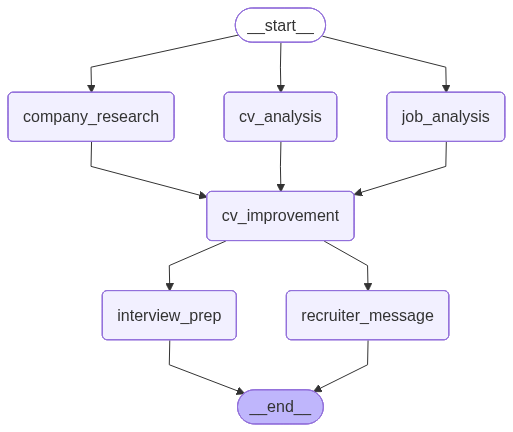

In [26]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# Example initial_state + run

initial_state: AgentState = {
    "company_name": "OpenAI",
    "job_description": "Senior ML Engineer — build and deploy production ML systems. Required: Python, PyTorch, model deployment, 5+ years experience.",
    "user_cv": "Ariane — ML engineer with 4 years experience in Python, PyTorch; deployments on AWS; worked on model optimization.",
    # metadata initial values (empty)
    "errors": [],
    "warnings": [],
    "execution_time": {}
}

# Run the workflow
print("⏳ Executing workflow...")
final_state = app.invoke(initial_state)

print("\n🎉 Final state summary (keys):")
print(list(final_state.keys()))
print("\nErrors:", final_state.get("errors"))
print("Execution times:", final_state.get("execution_time"))

✅ Setup Complete
🚀 CREATING WORKFLOW
📍 Adding nodes...
✅ Nodes added

📍 Adding edges...
✅ Layer 1: Initial parallel analysis
✅ Layer 2: Convergence to cv_improvement
✅ Layer 3: Parallel output generation
✅ Layer 4: End nodes
✅ Workflow successfully created!

⏳ Executing workflow...
✅ Job Analysis: Senior ML Engineer
✅ Company Research: OpenAI

🎉 Final state summary (keys):
['company_name', 'job_description', 'user_cv', 'company_info', 'job_analysis', 'cv_analysis', 'cv_improvements', 'recruiter_message', 'interview_prep', 'errors', 'warnings', 'execution_time']

Errors: []
Execution times: {'company_research': 4.333154201507568, 'job_analysis': 3.216411828994751}


In [ ]:
# Display Results

def display_complete_report(state: AgentState):
    """Display all results in a beautiful format"""
    
    print("\n" + "="*80)
    print(" " * 20 + "🎯 JOB APPLICATION ANALYSIS REPORT")
    print("="*80)
    
    # ─────────────────────────────────────────────────────────────
    # COMPANY SECTION
    # ─────────────────────────────────────────────────────────────
    
    if state.get("company_info"):
        print_section("COMPANY RESEARCH", "📍")
        co = state["company_info"]
        print(f"Company:      {co.get('name', 'N/A')}")
        print(f"Industry:     {co.get('industry', 'N/A')}")
        print(f"Size:         {co.get('size', 'N/A')} employees")
        print(f"\n📋 Mission:")
        print(f"  {co.get('mission', 'N/A')}")
        print(f"\n🏢 Culture:")
        print(f"  {co.get('culture', 'N/A')}")
        print(f"\n💻 Technologies:")
        technologies = co.get('technologies', [])
        for tech in technologies[:8]:
            print(f"  • {tech}")
        if len(technologies) > 8:
            print(f"  • ... and {len(technologies) - 8} more")
    
    # ─────────────────────────────────────────────────────────────
    # JOB SECTION
    # ─────────────────────────────────────────────────────────────
    
    if state.get("job_analysis"):
        print_section("JOB ANALYSIS", "💼")
        job = state["job_analysis"]
        print(f"Position:        {job.get('job_title', 'N/A')}")
        print(f"Experience Lvl:  {job.get('experience_level', 'N/A')}")
        print(f"Job Type:        {job.get('job_type', 'N/A')}")
        print(f"Location:        {job.get('location', 'N/A')}")
        print(f"Salary:          {job.get('salary_range', 'Not specified')}")
        
        req_skills = job.get("required_skills", [])
        print(f"\n✅ Required Skills ({len(req_skills)}):")
        for skill in req_skills:
            print(f"  • {skill}")
        
        nice_skills = job.get("nice_to_have_skills", [])
        if nice_skills:
            print(f"\n⭐ Nice-to-Have Skills ({len(nice_skills)}):")
            for skill in nice_skills[:5]:
                print(f"  • {skill}")
            if len(nice_skills) > 5:
                print(f"  • ... and {len(nice_skills) - 5} more")
        
        resp = job.get("key_responsibilities", [])
        print(f"\n📝 Key Responsibilities:")
        for r in resp:
            print(f"  • {r}")
    
    # ─────────────────────────────────────────────────────────────
    # CV ANALYSIS SECTION
    # ─────────────────────────────────────────────────────────────
    
    if state.get("cv_analysis"):
        print_section("YOUR CV ANALYSIS", "📄")
        cv = state["cv_analysis"]
        
        match_pct = cv.get("match_percentage", 0)
        bar_length = 20
        filled = int(bar_length * match_pct / 100)
        bar = "█" * filled + "░" * (bar_length - filled)
        
        print(f"Match Percentage: [{bar}] {match_pct}%")
        print(f"Years of Experience: {cv.get('experience_years', 0)} years")
        
        current = cv.get("current_skills", [])
        print(f"\n✓ Your Current Skills ({len(current)}):")
        for skill in current:
            print(f"  • {skill}")
        
        matching = cv.get("matching_skills", [])
        print(f"\n🎯 Matching Skills ({len(matching)}):")
        for skill in matching:
            print(f"  ✓ {skill}")
        
        gaps = cv.get("gap_skills", [])
        print(f"\n❌ Gap Skills - What You're Missing ({len(gaps)}):")
        for skill in gaps:
            print(f"  ✗ {skill}")
        
        strengths = cv.get("strengths", [])
        if strengths:
            print(f"\n💪 Your Strengths:")
            for s in strengths:
                print(f"  • {s}")
        
        weaknesses = cv.get("weaknesses", [])
        if weaknesses:
            print(f"\n⚠️ Areas to Improve:")
            for w in weaknesses:
                print(f"  • {w}")
    
    # ─────────────────────────────────────────────────────────────
    # CV IMPROVEMENTS SECTION
    # ─────────────────────────────────────────────────────────────
    
    if state.get("cv_improvements"):
        print_section("CV IMPROVEMENT RECOMMENDATIONS", "🚀")
        imp = state["cv_improvements"]
        
        print(f"⏱️  Estimated Time to Implement: {imp.get('estimated_time', 'N/A')}\n")
        
        print("📋 Priority Action Items:")
        for i, item in enumerate(imp.get("action_items", []), 1):
            print(f"  {i}. {item}")
        
        print(f"\n🔑 Keywords to Add to Your CV:")
        for kw in imp.get("new_keywords_to_add", []):
            print(f"  • {kw}")
        
        print(f"\n📝 Sections to Enhance:")
        for section, suggestion in imp.get("sections_to_enhance", {}).items():
            print(f"\n  [{section}]")
            print(f"  {suggestion}")
        
        print(f"\n💡 General Improvements:")
        for improvement in imp.get("improvements", []):
            print(f"  • {improvement}")
    
    # ─────────────────────────────────────────────────────────────
    # RECRUITER MESSAGE SECTION
    # ─────────────────────────────────────────────────────────────
    
    if state.get("recruiter_message"):
        print_section("RECRUITER MESSAGE TEMPLATE", "📧")
        msg = state["recruiter_message"]
        
        print(f"\n📌 Subject Line:")
        print(f"  \"{msg.get('subject_line', 'N/A')}\"")
        
        print(f"\n📬 Email Body:")
        print("─" * 80)
        print(msg.get("message_body", "N/A"))
        print("─" * 80)
        
        print(f"\n⭐ Key Highlights to Mention:")
        for highlight in msg.get("key_highlights", []):
            print(f"  • {highlight}")
        
        print(f"\n🤝 Call to Action:")
        print(f"  {msg.get('call_to_action', 'N/A')}")
    
    # ─────────────────────────────────────────────────────────────
    # INTERVIEW PREP SECTION
    # ─────────────────────────────────────────────────────────────
    
    if state.get("interview_prep"):
        print_section("INTERVIEW PREPARATION", "🎤")
        prep = state["interview_prep"]
        
        questions = prep.get("interview_questions", [])
        print(f"\n💼 Expected Interview Questions ({len(questions)}):\n")
        
        for i, q_obj in enumerate(questions, 1):
            print(f"  Q{i}: {q_obj.get('question', 'N/A')}")
            print(f"       Why asked: {q_obj.get('why_asked', 'N/A')}")
            print(f"       Answer framework: {q_obj.get('answer_framework', 'N/A')}")
            print(f"       Tips:")
            for tip in q_obj.get("tips", []):
                print(f"         • {tip}")
            print()
        
        company_qs = prep.get("company_questions", [])
        print(f"\n🔍 Smart Questions to Ask About the Company/Role ({len(company_qs)}):")
        for q in company_qs:
            print(f"  • {q}")
        
        talking_points = prep.get("company_research_talking_points", [])
        print(f"\n📊 Company Research Talking Points ({len(talking_points)}):")
        for point in talking_points:
            print(f"  • {point}")
        
        strengths = prep.get("strengths_to_emphasize", [])
        print(f"\n💪 Your Strengths to Emphasize ({len(strengths)}):")
        for strength in strengths:
            print(f"  • {strength}")
        
        tips = prep.get("tips", [])
        print(f"\n💡 Interview Tips ({len(tips)}):")
        for tip in tips:
            print(f"  • {tip}")
    
    # ─────────────────────────────────────────────────────────────
    # ERRORS & WARNINGS
    # ─────────────────────────────────────────────────────────────
    
    errors = state.get("errors", [])
    warnings = state.get("warnings", [])
    
    if errors or warnings:
        print_section("WARNINGS & ERRORS", "⚠️")
        
        if warnings:
            print("⚠️ Warnings:")
            for warning in warnings:
                print(f"  {warning}")
        
        if errors:
            print("\n❌ Errors:")
            for error in errors:
                print(f"  {error}")
    
    # ─────────────────────────────────────────────────────────────
    # EXECUTION TIME
    # ─────────────────────────────────────────────────────────────
    
    exec_time = state.get("execution_time", {})
    if exec_time:
        print_section("EXECUTION TIME", "⏱️")
        total_time = sum(exec_time.values())
        for agent, time_taken in exec_time.items():
            print(f"  {agent}: {time_taken:.2f}s")
        print(f"  ─────────────────")
        print(f"  Total: {total_time:.2f}s")
    
    print("\n" + "="*80 + "\n")

In [ ]:
# Run the Workflow

print("="*80)
print("🚀 STARTING MULTI-AGENT CV ANALYSIS WORKFLOW")
print("="*80)
print(f"\nAnalyzing application to: {company_name}")
print(f"\n" + "-"*80 + "\n")

# Create initial state
initial_state: AgentState = {
    "company_name": company_name,
    "job_description": job_description,
    "user_cv": user_cv,
    "company_info": None,
    "job_analysis": None,
    "cv_analysis": None,
    "cv_improvements": None,
    "recruiter_message": None,
    "interview_prep": None,
    "errors": [],
    "warnings": [],
    "execution_time": {}
}

# Run the workflow
print("⏳ Executing workflow...")

final_state = app.invoke(initial_state)

🚀 STARTING MULTI-AGENT CV ANALYSIS WORKFLOW

Analyzing application to: Google

--------------------------------------------------------------------------------

⏳ Executing workflow...
✅ Company Research: Google
✅ Job Analysis: Senior Backend Engineer - Cloud Infrastructure


In [ ]:
# Display report of the agentic system

display_complete_report(final_state)


                    🎯 JOB APPLICATION ANALYSIS REPORT

📍 COMPANY RESEARCH
───────────────────
Company:      Google
Industry:     Technology and Internet Services
Size:         Approximately 156,500 employees employees

📋 Mission:
  To organize the world's information and make it universally accessible and useful.

🏢 Culture:
  Google fosters an open and innovative work environment that encourages creativity, collaboration, and inclusion. The company values diversity, employee well-being, and continuous learning.

💻 Technologies:
  • Google Cloud Platform
  • TensorFlow
  • Android
  • Kubernetes

💼 JOB ANALYSIS
───────────────
Position:        Senior Backend Engineer - Cloud Infrastructure
Experience Lvl:  Senior
Job Type:        Full-time
Location:        Mountain View, CA (Remote Option Available)
Salary:          $200,000 - $300,000 + equity and benefits

✅ Required Skills (8):
  • 5+ years of professional software development experience
  • Expert-level knowledge of Python, Java, 